# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`

In [544]:
import re

df=pd.DataFrame(columns=["title","year", "imdb", "metascore", "votes", "us_gross", "time"])
movies=[]
PAGE_NUMBER=1

while True:
    r=requests.get(url=f'https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt', headers={"Accept-Language": "en-US,en;q=0.5"})
    soup= BeautifulSoup(r.content, 'html.parser')
    PAGE_NUMBER= PAGE_NUMBER+50

    tables = soup.find_all(class_="lister-item mode-advanced")
    movies=[]
    for table in tables:

        #title
        title=table.find_all(class_="lister-item-header")
        title=str(title)
        title=title[title.find("href")+10:title.find("</a>")+2]
        title=title[title.find('>')+1:title.find('<')]

        #year
        year=table.find_all(class_="lister-item-year text-muted unbold")
        year=re.findall(r'\d+', str(year))[0]

        #imdb
        rating=table.find_all(class_="inline-block ratings-imdb-rating")
        rating=re.findall(r'\d+\.*\d*', str(rating))[0]

        #meta
        meta=table.find_all(class_="metascore favorable")
        if meta:
            meta=re.findall(r'\d+', str(meta))[0]

        else:
            meta=np.nan

        #votes
        votes=table.find_all(class_="sort-num_votes-visible")
        votes=re.findall(r'\d+', str(votes))[0]

        #gross
        last=table.find_all("span")[-1]
        last=str(last)
        if "$" in last:
            gross=re.findall(r'\d+\.*\d*', last)[-1]
        else:   
            gross=np.nan

        #time
        run=table.find_all(class_="runtime")
        run=re.findall(r'\d+', str(run))[0]

        movies.append({ 
            "title":title,
            "year":year,
            "imdb":rating,
            "metascore":meta,
            "votes":votes,
            "us_gross":gross,
            "time":run
                            })

        # df2=pd.DataFrame(movies)

    df=df.append(movies, ignore_index=True)

    

    if PAGE_NUMBER >952:
        break


df

,title,year,imdb,metascore,votes,us_gross,time
0,Dune,2021,8.2,74,358330,NaN,155
1,Jai Bhim,2021,9.5,NaN,146802,NaN,164
2,Ghostbusters,1984,7.8,71,384213,238.63,105
3,Home Alone,1990,7.6,63,516782,285.76,103
4,Harry Potter and the Sorcerer's Stone,2001,7.6,65,711686,317.58,152
...,...,...,...,...,...,...,...
995,Vizontele,2001,8,NaN,35481,NaN,110
996,Black,2005,8.2,NaN,34339,0.73,122
997,The Breath,2009,8,NaN,32994,NaN,128
998,"Carry On, Munna Bhai",2006,8.1,NaN,45561,2.22,144


In [551]:
df["length"]=df.title.str.len()
df["length_2"]=df.length**2
df["length_3"]=df.length**3

In [552]:
df.head()

,title,year,imdb,metascore,votes,us_gross,time,length,length_2,length_3
0,Dune,2021,8.2,74,358330,NaN,155,4,16,64
1,Jai Bhim,2021,9.5,NaN,146802,NaN,164,8,64,512
2,Ghostbusters,1984,7.8,71,384213,238.63,105,12,144,1728
3,Home Alone,1990,7.6,63,516782,285.76,103,10,100,1000
4,Harry Potter and the Sorcerer's Stone,2001,7.6,65,711686,317.58,152,37,1369,50653


In [553]:
df.sort_values(by="length")

,title,year,imdb,metascore,votes,us_gross,time,length,length_2,length_3
662,Z,1969,8.2,86,26451,0.08,127,1,1,1
505,M,1931,8.3,NaN,151942,0.03,99,1,1,1
602,8½,1963,8.0,91,114352,0.05,138,2,4,8
655,PK,2014,8.1,NaN,174004,10.62,153,2,4,8
509,96,2018,8.6,NaN,25991,NaN,158,2,4,8
...,...,...,...,...,...,...,...,...,...,...
285,Star Wars: Episode V - The Empire Strikes Back,1980,8.7,82,1216133,290.48,124,46,2116,97336
325,Birdman or (The Unexpected Virtue of Ignorance),2014,7.7,87,605512,42.34,119,47,2209,103823
19,The Lord of the Rings: The Fellowship of the Ring,2001,8.8,92,1747741,315.54,178,49,2401,117649
114,Pirates of the Caribbean: The Curse of the Bla...,2003,8.0,63,1052150,305.41,143,54,2916,157464


In [554]:
1.5/2

0.75

In [519]:
import statsmodels.api as sm

In [547]:
df=df.dropna(subset=['imdb'])



# x=df[["length", "length_2", "length_3"]]
# x=sm.add_constant(x)
df.imdb=df.imdb.astype(np.float64)

In [548]:
df.imdb.unique()

array([8.2, 9.5, 7.8, 7.6, 9.3, 9.2, 8.4, 8.7, 7.9, 8.6, 8. , 8.8, 8.3,
       9. , 8.9, 8.1, 8.5, 7.7, 9.1])

In [536]:
df.imdb.dtype

dtype('O')

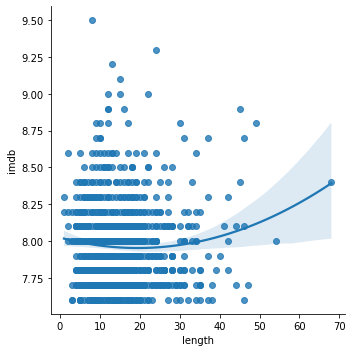

In [557]:
sns.lmplot(x="length", y="imdb",data=df, order=2)

In [523]:
est=sm.OLS(endog=y, exog=x).fit()
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   imdb   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.469
Date:                Tue, 30 Nov 2021   Prob (F-statistic):             0.0606
Time:                        00:52:52   Log-Likelihood:                -142.81
No. Observations:                1000   AIC:                             293.6
Df Residuals:                     996   BIC:                             313.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0070      0.046    175.699      0.000       7.918       8.096
length        -0.0043      0.007     -0.626      0.531      -0.018       0.009
length_2    4.684e-05      0.000      0.158      0.875      -0.001       0.001
length_3    1.766e-06   3.62e-06      0.488      0.626   -5.34e-06    8.87e-06
==============================================================================
Omnibus:                      203.110   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.204
Skew:                           1.144   Prob(JB):                     4.66e-93
Kurtosis:                       5.229   Cond. No.                     9.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""